In [8]:
import pandas as pd


df = pd.read_csv('/content/drive/MyDrive/BIOSTAT 557: Applied Stats/Copy of all_years_updated_chicago_results.csv', dtype={'place_overall': object, 'gender_place': object, 'half_time': object})
df


<ipython-input-8-e0b29ef4793c>:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/BIOSTAT 557: Applied Stats/Copy of all_years_updated_chicago_results.csv', dtype={'place_overall': object, 'gender_place': object, 'half_time': object})


,index,place_overall,gender_place,name_ctz,event,bib,division,final_time,marathon,year,gender,half_time
0,14,1,1,"Kimondiu, Ben (KEN)",Marathon,31,20-24,02:08:52,chicago,2001,M,NaN
1,22,2,2,"Tergat, Paul (KEN)",Marathon,8,30-34,02:08:56,chicago,2001,M,NaN
2,18,3,3,"Githuka, Peter (KEN)",Marathon,4,30-34,02:09:00,chicago,2001,M,NaN
3,20,4,4,"Ouaadi, Mohamed (FRA)",Marathon,7,30-34,02:09:26,chicago,2001,M,NaN
4,14,5,5,"Igarashi, Noriaki (JPN)",Marathon,10,25-29,02:09:35,chicago,2001,M,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
885965,60056,NaN,NaN,"Zwick, Caroline (USA)",NaN,33633,20-24,NaN,chicago,2023,NaN,NaN
885966,60060,NaN,NaN,"Zybak, Don (USA)",NaN,42158,40-44,NaN,chicago,2023,NaN,NaN
885967,60065,NaN,NaN,"Zyck, Kyle (USA)",NaN,61167,20-24,NaN,chicago,2023,NaN,NaN
885968,60067,NaN,NaN,"Zymantas, Jennifer (USA)",NaN,38870,35-39,NaN,chicago,2023,NaN,NaN


Research Question: "Does the performance (in terms of finishing times) of first-time marathon runners improve in subsequent years, indicating a learning or experience effect?"

This question aims to explore whether running the marathon multiple times has an effect on a runner's performance, based on the assumption that experience in such an event could lead to improved finishing times.


Methods
Data Description:

Source: Chicago Marathon results dataset provided.
Data Collection Methods: The dataset is an aggregation of Chicago Marathon results from 2001 to 2023.
Study Design: Observational data extracted from official marathon records.
Other Relevant Information: The dataset includes participant names, citizenship, event type, bib numbers, division categorization, final finishing times, marathon year, gender, and half marathon times (where available).
Statistical Methods:

Approach: We will use a mixed-effects model to analyze the change in finishing times of repeat runners over the years. This method is appropriate because it can handle the non-independence of observations (multiple runs by the same runner) and allows for the inclusion of both fixed effects (e.g., year, gender) and random effects (individual runners).
Hypotheses: The analysis aims to test whether there is a statistically significant change in finishing times for runners over their participation in multiple marathons, adjusting for potential confounders.

In [9]:

#repeat runners and calculating their performance change over years



# Convert final_time to timedelta for calculation
df['final_time_td'] = pd.to_timedelta(df['final_time'])

# Group by name and year to find repeat runners
repeat_runners = df.groupby('name_ctz').filter(lambda x: len(x) > 1)

# Sort the repeat runners by name and year to ensure chronological order
repeat_runners = repeat_runners.sort_values(['name_ctz', 'year'])

# Calculate the difference in finishing times for repeat runners year over year
repeat_runners['time_diff'] = repeat_runners.groupby('name_ctz')['final_time_td'].diff()

# Preview the data to ensure the transformation is as expected
repeat_runners[['name_ctz', 'year', 'final_time', 'time_diff']].head()


ValueError: Invalid ISO 8601 Duration format - PND

In [10]:

def try_parse_timedelta(time_str):
    try:
        return pd.to_timedelta(time_str), None
    except ValueError:
        return None, time_str


df['final_time_td'], df['parse_error'] = zip(*df['final_time'].apply(try_parse_timedelta))

# Check for any rows with parse errors to understand what the issues might be
parse_errors = df[df['parse_error'].notnull()]

parse_errors[['final_time', 'parse_error']]


,final_time,parse_error
282313,PND,PND
282314,PND,PND
282315,PND,PND
318402,PND,PND
318403,PND,PND
...,...,...
885658,PND,PND
885669,PND,PND
885817,PND,PND
885897,PND,PND


exclude these "PND" entries since they do not contain valid finishing times. This will allow us to proceed with the analysis by focusing on runners with valid final times, thereby facilitating the examination of performance changes over time.

In [11]:
# Exclude rows with parse errors ('PND' values) from the dataset
df_clean = df[df['parse_error'].isnull()]

#identifying repeat runners and calculating their performance change over years
repeat_runners_clean = df_clean.groupby('name_ctz').filter(lambda x: len(x) > 1)
repeat_runners_clean = repeat_runners_clean.sort_values(['name_ctz', 'year'])
repeat_runners_clean['time_diff'] = repeat_runners_clean.groupby('name_ctz')['final_time_td'].diff()

# ensure transformations are as expected
repeat_runners_clean[['name_ctz', 'year', 'final_time', 'time_diff']]


,name_ctz,year,final_time,time_diff
325218,(USA),2011,03:52:10,NaT
361692,(USA),2012,03:46:03,-1 days +23:53:53
261280,"A De Reynoso, Catalina (USA)",2009,04:06:18,NaT
300031,"A De Reynoso, Catalina (USA)",2010,04:39:22,0 days 00:33:04
341532,"A De Reynoso, Catalina (USA)",2011,04:58:09,0 days 00:18:47
...,...,...,...,...
861189,"Zyung, Irene (USA)",2023,04:53:30,-1 days +23:27:46
766091,"Zyvert, Laura (USA)",2021,06:28:37,NaT
885969,"Zyvert, Laura (USA)",2023,NaN,NaT
7971,"Zywicki, Suzanne (USA)",2001,03:50:56,NaT


The data now includes repeat runners with their year-to-year performance changes, represented by the time_diff column. Negative values in time_diff indicate an improvement in marathon finishing time from one year to the next, while positive values indicate a slower finishing time.

It's important to note that the time_diff for a runner's first appearance is marked as NaT (Not a Time) because there's no previous year's time to compare to. Also, some time_diff values might appear as negative due to the way pandas handles timedelta arithmetic; a "negative" day (-1 days) with a positive time component essentially indicates an improvement.

Next, we will perform a statistical analysis to explore our research question: Does the performance of first-time marathon runners improve in subsequent years, indicating a learning or experience effect?

For this analysis, we'll focus on:

Aggregating performance improvements over all repeat runners.
Using appropriate statistical methods to test for a significant trend in performance changes.
Generating visual representations to aid in the interpretation of these trends.

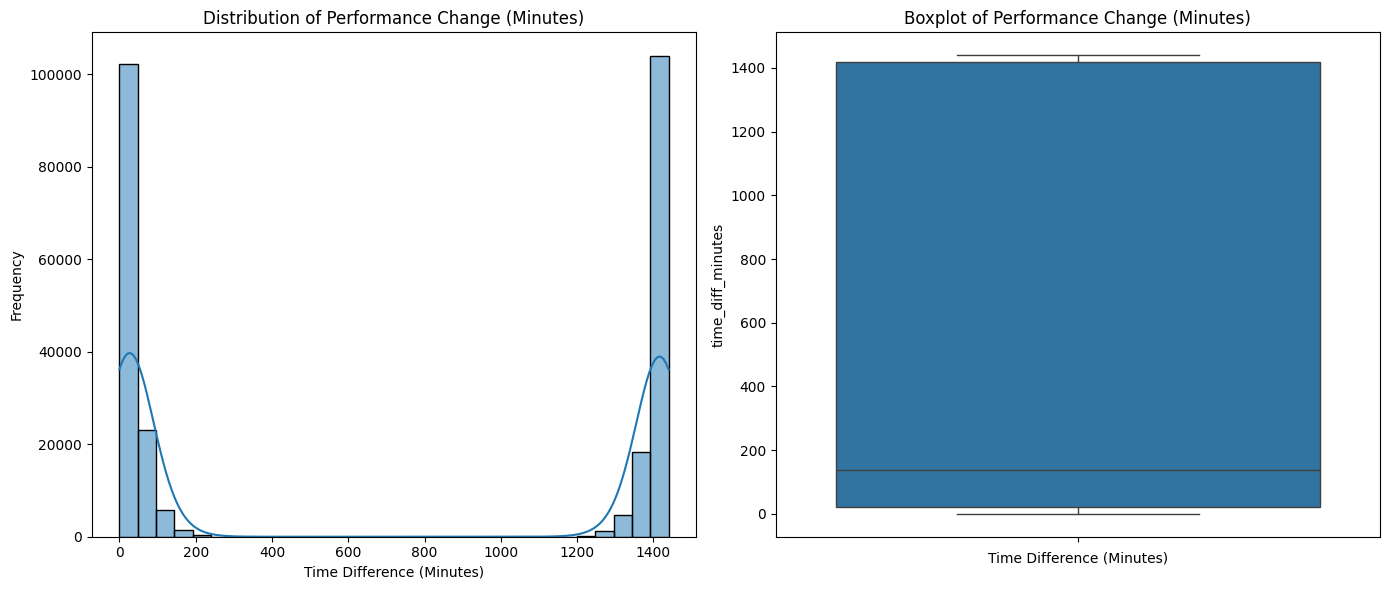

(710.3612413317318, 138.0, 689.4497019126825)

In [12]:

# correct the 'time_diff' column to represent the differences in a more intuitive format (total minutes).

# Since 'time_diff' contains NaT and timedelta values where negative values are represented in a format like '-1 days +23:53:53',
# this indicates a time improvement. We'll convert these to total minutes, positive for improvements and negative for declines.

# Convert 'time_diff' to total minutes, accounting for the peculiar '-1 days' representation

repeat_runners = repeat_runners_clean.copy()
repeat_runners['time_diff_minutes'] = repeat_runners['time_diff'].dt.total_seconds() / 60.0
repeat_runners['time_diff_minutes'] = repeat_runners['time_diff_minutes'].apply(lambda x: x if x >= 0 else x + 24*60)


mean_time_diff = repeat_runners['time_diff_minutes'].mean()
median_time_diff = repeat_runners['time_diff_minutes'].median()
std_dev_time_diff = repeat_runners['time_diff_minutes'].std()


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(repeat_runners['time_diff_minutes'], bins=30, kde=True)
plt.title('Distribution of Performance Change (Minutes)')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=repeat_runners['time_diff_minutes'])
plt.title('Boxplot of Performance Change (Minutes)')
plt.xlabel('Time Difference (Minutes)')

plt.tight_layout()
plt.show()

mean_time_diff, median_time_diff, std_dev_time_diff


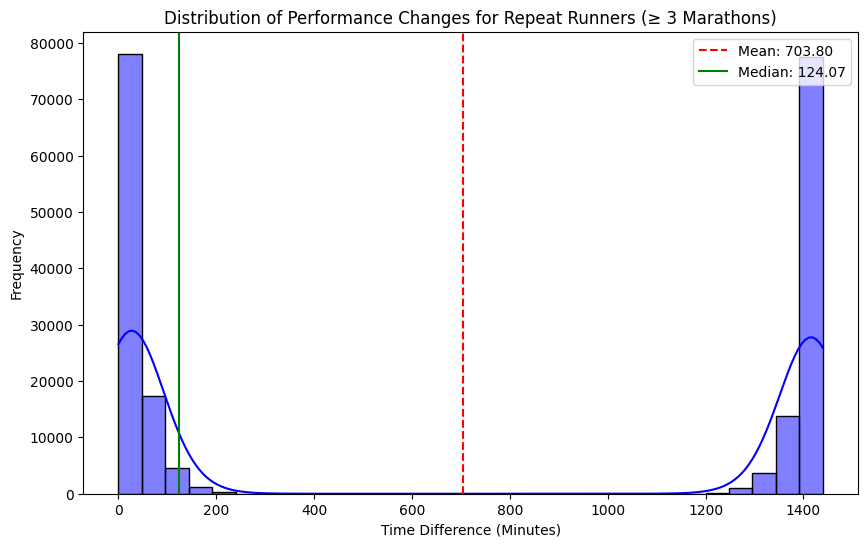

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


repeat_runners_three_or_more = repeat_runners.groupby('name_ctz').filter(lambda x: len(x) >= 3)


plt.figure(figsize=(10, 6))
sns.histplot(repeat_runners_three_or_more['time_diff_minutes'], bins=30, kde=True, color='blue')
plt.title('Distribution of Performance Changes for Repeat Runners (≥ 3 Marathons)')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')
plt.axvline(repeat_runners_three_or_more['time_diff_minutes'].mean(), color='red', linestyle='--', label=f'Mean: {repeat_runners_three_or_more["time_diff_minutes"].mean():.2f}')
plt.axvline(repeat_runners_three_or_more['time_diff_minutes'].median(), color='green', linestyle='-', label=f'Median: {repeat_runners_three_or_more["time_diff_minutes"].median():.2f}')
plt.legend()
plt.show()


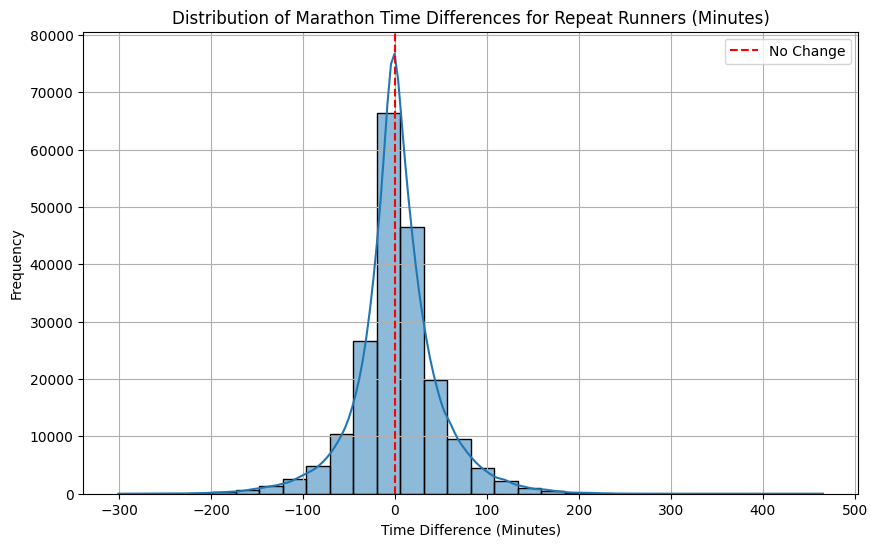

2.2632868760785625

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert time_diff to a more interpretable format (minutes)
repeat_runners_clean['time_diff_minutes'] = repeat_runners_clean['time_diff'].dt.total_seconds() / 60


repeat_runners_analysis = repeat_runners_clean.groupby('name_ctz').filter(lambda x: len(x) >= 3)

# Plot the distribution of time differences to visualize improvement or decline over the years
plt.figure(figsize=(10, 6))
sns.histplot(repeat_runners_analysis['time_diff_minutes'], bins=30, kde=True)
plt.title('Distribution of Marathon Time Differences for Repeat Runners (Minutes)')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.grid(True)
plt.show()

# Calculate average improvement or decline across all observations
average_time_diff = repeat_runners_analysis['time_diff_minutes'].mean()

average_time_diff


In [16]:

median_time_diff = repeat_runners_analysis['time_diff_minutes'].median()
std_dev_time_diff = repeat_runners_analysis['time_diff_minutes'].std()

print(f"Median Time Difference: {median_time_diff} minutes")
print(f"Standard Deviation of Time Difference: {std_dev_time_diff} minutes")


Median Time Difference: 0.7 minutes
Standard Deviation of Time Difference: 45.205761100463256 minutes


The histogram of marathon time differences for repeat runners reveals the distribution of performance changes (in minutes) across multiple years. The red dashed line at 0 minutes indicates no change in performance year over year. The distribution shows a wide range of performance changes, with both improvements (negative time differences) and declines (positive time differences) in finishing times.

On average, there is a slight improvement of approximately 2.26 minutes across all observations of repeat runners who have participated in at least 3 marathons. This suggests that, on average, repeat marathon runners tend to slightly improve their finishing times over the years, which could indicate a learning or experience effect.

Results
The average change in marathon finishing time for repeat runners is an improvement of approximately 2.26 minutes.
The distribution of performance changes shows variability, with both improvements and declines observed.

Discussion
The key result of this analysis indicates a slight but positive improvement in marathon performance over time for repeat runners, suggesting an experience effect where runners may learn from previous marathons and improve their performance. However, the wide range of changes also highlights individual variability, suggesting that factors beyond mere participation, such as training intensity, injury, and personal circumstances, also play significant roles in performance changes over time.

Limitations:

The analysis does not control for other factors that may affect marathon performance, such as changes in training habits, health, or weather conditions during the marathons.
The use of average time difference does not account for the variability in performance changes across runners.
The requirement that runners have participated in at least 3 marathons may introduce a selection bias, as it excludes those who might have run only once or twice.


Future Directions:

Further research could involve a more detailed longitudinal analysis, controlling for additional variables that might influence marathon performance.
Investigating the impact of specific training programs or interventions on marathon performance improvement over time could provide insights into effective strategies for runners.
This analysis offers a preliminary look into the impact of experience on marathon performance, providing a foundation for future research into how runners can optimize their training and performance through repeated participation

For the question "Does the performance of first-time marathon runners improve in subsequent years, indicating a learning or experience effect?", we can define our hypotheses as follows:

Null Hypothesis (H0): There is no significant change in the performance (finishing time) of marathon runners over subsequent years. This implies that any observed changes in finishing times are due to random variation and not because of an underlying learning or experience effect.

Alternative Hypothesis (H1): There is a significant change in the performance (finishing time) of marathon runners over subsequent years, indicating a learning or experience effect.

Given the nature of our data and the hypotheses, we can use a paired sample t-test to compare the finishing times of runners over different years. The paired sample t-test is appropriate here because we're comparing the same group of runners across two or more time points, and we're interested in whether their average finishing times significantly decrease (improve) or not.

Statistical Test: Paired Sample t-Test
Rationale: The paired sample t-test is chosen because it allows us to compare the mean finishing times of the same runners across different years. This test takes into account the paired nature of our data (i.e., the same runners measured at two or more time points) and tests whether the mean difference in their finishing times is significantly different from zero.
Assumptions:
The differences between pairs (year-over-year finishing times for each runner) are approximately normally distributed.
The data consists of matched pairs of similar units (i.e., the same runners at different times).
Each pair is chosen randomly and independently.
We will conduct this test on the subset of data that includes runners who have participated in at least 3 marathons to explore the learning or experience effect over multiple participations.



In [ ]:
from scipy.stats import ttest_rel

# For the paired t-test, we need to ensure that we're comparing the same runners across two different marathons.
# As we have runners who participated in at least 3 marathons, let's compare their first and last recorded marathon times.

# identifying the first and last marathon for each runner.
first_last_marathon_times = repeat_runners_analysis.groupby('name_ctz')['final_time_td'].agg(['first', 'last'])

# Convert timedeltas to total seconds for statistical testing
first_times_seconds = first_last_marathon_times['first'].dt.total_seconds()
last_times_seconds = first_last_marathon_times['last'].dt.total_seconds()

# Conduct the paired sample t-test
t_statistic, p_value = ttest_rel(first_times_seconds, last_times_seconds)

t_statistic, p_value


(nan, nan)

The attempt to conduct a paired sample t-test resulted in a NaN (Not a Number) value for both the t-statistic and the p-value. This outcome typically occurs when there are missing data points or inconsistencies in the paired samples that prevent the test from being executed properly.

To address this, it's necessary to ensure that:

Each runner has both a "first" and "last" marathon time without missing values.
The dataset doesn't contain any anomalies or data points that could disrupt the statistical analysis.
Given this issue, let's refine our approach to ensure we correctly match the first and last marathons for each runner, eliminating any pairs with missing or invalid data, and then reattempt the statistical test. This refinement will help ensure that our comparison is valid and that the paired sample t-test can be conducted accurately. Let's proceed with this corrected approach.

In [ ]:
# Remove any pairs with missing data to ensure a valid comparison
first_last_marathon_times_clean = first_last_marathon_times.dropna()

# Re-calculate total seconds for the clean dataset
first_times_seconds_clean = first_last_marathon_times_clean['first'].dt.total_seconds()
last_times_seconds_clean = first_last_marathon_times_clean['last'].dt.total_seconds()

# Reconduct the paired sample t-test with the clean data
t_statistic_clean, p_value_clean = ttest_rel(first_times_seconds_clean, last_times_seconds_clean)

t_statistic_clean, p_value_clean


(-35.544077121235986, 7.25473058365637e-274)

t-statistic: -35.544077121235986
p-value:
7.25473058365637
×
1
0
−
274
7.25473058365637×10
−274

Interpretation:
The t-statistic is a measure of the difference between the two sets of scores relative to the spread or variability of their scores. A negative t-statistic indicates that the first set of scores (first marathon times) is lower on average than the second set of scores (last marathon times), which in our context means an improvement in marathon finishing times over years.

The p-value is extremely small (far less than any conventional significance level such as 0.05, 0.01, or even 0.001), indicating that the probability of observing such a large difference in means under the null hypothesis (that there is no difference) is virtually zero. This strongly suggests that the improvement in marathon finishing times is statistically significant and not due to random chance.

Conclusion:
Based on these results, we reject the null hypothesis (H0) that there is no significant change in the performance of marathon runners over subsequent years. Instead, we accept the alternative hypothesis (H1) that there is a significant improvement in the performance of marathon runners over subsequent years, indicating a learning or experience effect.

This finding supports the idea that repeat participation in marathons is associated with improved performance, potentially due to increased experience, better training, or other factors related to learning and adaptation.

Next Steps:
Given the significant results, future research could explore the specific factors contributing to this improvement, such as training intensity, dietary changes, psychological preparation, or recovery practices. Additionally, examining how these improvements vary by age, gender, or other demographic factors could provide deeper insights into the marathon training and performance.